
<font size = "5"> **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Kinematic Scattering Geometry

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Diffraction/CH2_06-Kinematic_Scattering_Geometry.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main//Diffraction/CH2_06-Kinematic_Scattering_Geometry.ipynb)
 
part of

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

**Spring 2025**<br>
by Gerd Duscher

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville



Background and methods to analysis and quantification of data acquired with transmission electron microscopes.



## Load relevant python packages
### Check Installed Packages

In [1]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.1.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@main -q --upgrade

if 'google.colab' in sys.modules:
    !{sys.executable} -m pip install numpy==1.24.4
print('done')

installing pyTEMlib
done


### Load the plotting and figure packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,
* three dimensional plotting
and some libraries from the book
* kinematic scattering library.

In [16]:
%matplotlib  widget
import matplotlib.pyplot as plt
import numpy as np
import sys
if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()

# 3D plotting package 
from mpl_toolkits.mplot3d import Axes3D # 3D plotting
from matplotlib import patches

# additional package 
import  itertools 
import scipy

# Import libraries from the book
import pyTEMlib
import pyTEMlib.kinematic_scattering as ks         # Kinematic sCattering Library
                             # with Atomic form factors from Kirklands book
    
# it is a good idea to show the version numbers at this point for archiving reasons.
__notebook_version__ = '2022.01.21'
print('pyTEM version: ', pyTEMlib.__version__)
print('notebook version: ', __notebook_version__)

pyTEM version:  0.2024.01.1
notebook version:  2022.01.21


## Bragg's Law

$$ \Large
2d \sin{\theta} = n \lambda
$$

with:
- d: interplanar spacing
- $\theta$: Bragg angle
- $\lambda$: wavelength

The origin of Bragg's law is most conveniently explained in real space, but we want to understand the Ewald sphere construction, one of the most omportant concepts in diffraction.

real space | reciprocal space | wave vectors | shifted wave vectors | Ewald sphere
- | - | - | - | -
<img src="images/Bragg-1.jpg" alt="Bragg's Law" width="200" >|<img src="images/Bragg-3.jpg" alt="Bragg's Law" width="200" >|<img src="images/Bragg-4.jpg" alt="Bragg's Law" width="200" >|<img src="images/Bragg-5.jpg" alt="Bragg's Law" width="200" >|<img src="images/Bragg-6.jpg" alt="Bragg's Law" width="200" >

## Reciprocal Space


### Define silicon crystal

In [17]:
#Initialize the dictionary with all the input
atoms = ks.structure_by_name('Silicon')

print(atoms)
print(atoms.get_scaled_positions())

Lattice(symbols='Si8', pbc=True, cell=[5.43088, 5.43088, 5.43088])
[[0.   0.   0.  ]
 [0.25 0.25 0.25]
 [0.5  0.5  0.  ]
 [0.75 0.75 0.25]
 [0.5  0.   0.5 ]
 [0.75 0.25 0.75]
 [0.   0.5  0.5 ]
 [0.25 0.75 0.75]]


### Wavelength and Magnitude of Incident Wavevector

In [18]:
acceleration_voltage_V = 200.0 *1000.0 #V

wave_length_A  = ks.get_wavelength(acceleration_voltage_V)

print('The wavelength for {0:.1f}kV is : {1:.5f}pm'.format(acceleration_voltage_V/1000.,wave_length_A*100.))

wave_vector_magnitude = 1/wave_length_A
K0_magnitude = wave_vector_magnitude

print('The magnitude of the incident wavevector is {0:.1f} 1/Ang'.format(K0_magnitude*10) )

The wavelength for 200.0kV is : 2.50793pm
The magnitude of the incident wavevector is 398.7 1/Ang


### Reciprocal Lattice and Incident Wavevector

We use ase to invert the unit_cell "matrix" to get the reciprocal cell

And we calculate the incident wave vector from 
- this reciprocal cell, 
- Miller indices of the zone axis and  
- wavelength

In [4]:
zone = [0, 0, 1] #Parallel to z-axis for simplicity

# Reciprocal Lattice 
#  We use ase to invert the unit_cell "matrix"
reciprocal_lattice = atoms.cell.reciprocal() # transposed of inverted unit_cell: np.linalg.inv(atoms.cell]).T

print('reciprocal lattice\n', reciprocal_lattice)

# Incident wavevector in vacuum 
# zone axis in global coordinate system
zone_vector = np.dot(zone, reciprocal_lattice)
K0_unit_vector = zone_vector / np.linalg.norm(zone_vector) # incident unit wave vector 
K0_vector = K0_unit_vector * K0_magnitude

print('Incident wavevector: ',K0_vector,' in units of [1/Ang]')

reciprocal lattice
 Cell([0.18413222166573373, 0.18413222166573373, 0.18413222166573373])
Incident wavevector:  [ 0.          0.         39.87345688]  in units of [1/Ang]


### 2D Plot of Unit Cell in Reciprocal Space

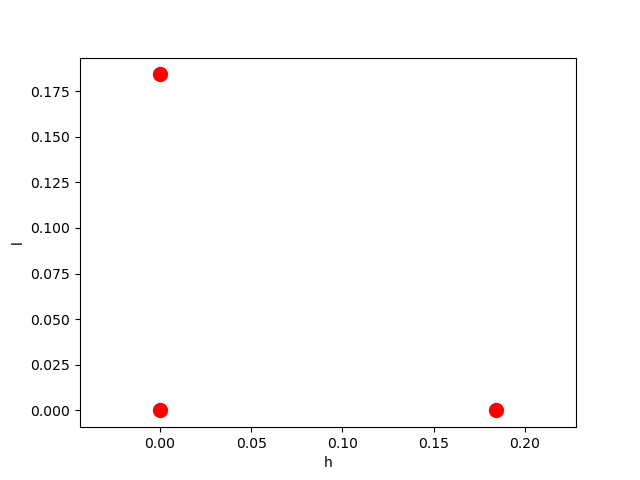

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(reciprocal_lattice[:,0], reciprocal_lattice[:,2], c='red', s=100)
plt.xlabel('h')
plt.ylabel('l')
ax.axis('equal');

### 2D plot of Reciprocal Lattice

Now we get all possible Miller (negative and positive) indices up to a maximum value 

We do get those combination with the itertool package.

(-9.9, 9.9, -9.9, 9.9)

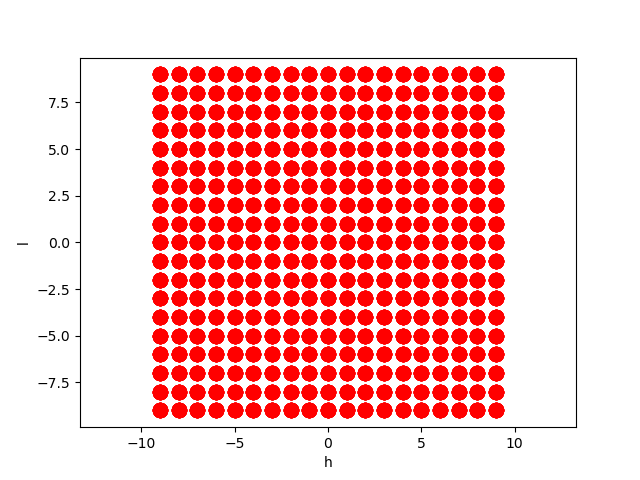

In [20]:
hkl_max = 9
indices = np.linspace(-hkl_max,hkl_max, 2*hkl_max+1)   # all evaluated single Miller Indices
hkl = np.array(list(itertools.product(indices, indices, indices))) # all evaluated Miller indices

# Plot 2D
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(hkl[:,0], hkl[:,2], c='red', s=100)
plt.xlabel('h')
plt.ylabel('l')
ax.axis('equal')

### Origin and Laue Zones
We really do not need that many reflections in the z-direction, so we reduce those.

We chose a spot in a reciprocal lattice (3 dimensional, but we usually draw only a two dimensional projection), where we let `end` the incident wavevector $\vec{k}_I$. 



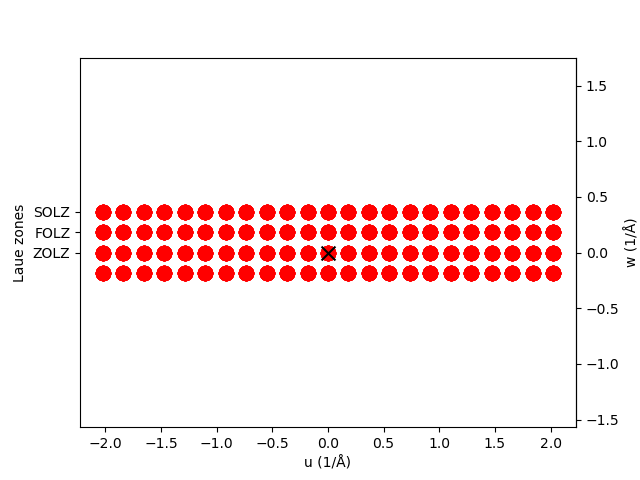

In [21]:
hkl_max = 11
indices_u_v  = np.linspace(-hkl_max, hkl_max, 2*hkl_max+1)  # all evaluated single Miller Indices
indices_w =  np.linspace(-1, 2,4)  # all evaluated single Miller Indices 
hkl  = np.array(list(itertools.product(indices_u_v, indices_u_v, indices_w))) # all evaluated Miller indices

g = np.dot(hkl, reciprocal_lattice) # all evaluated reciprocal lattice points

# Plot 2D
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(g[:,0], g[:,2], c='red', s=100)
ax.axis('equal')
secax_y = ax.secondary_yaxis('right')
secax_y.set_ylabel('w (1/Å)')
ax.set_yticks(g[1:4,2])
ax.set_yticklabels(['ZOLZ', 'FOLZ', 'SOLZ'])
plt.xlabel('u (1/Å)')
plt.ylabel('Laue zones') 
ax.scatter(0, 0, c='black', s=100, marker='x');

Here we defined the `Laue zones` (look at the right for the lables of the w-axis).
You are most familiar with the ``Zero Order Laue Zone (ZOLZ)``, the only Laue zone reachable with X-rays.

However the reciprocal lattice points do not lay only in one plane and so other orders exist as well.
These other planes are called ``Higher Order Laue Zones or HOLZ``.

the first few higher order Laue zones have extra names:
- FOLZ: first order Laue zone
- SOLZ: second order Laue zone

In electron diffraction these planes can diffract and so we need to consider them, moreover, they allow for very precise measurements.

### Ewald Sphere


The origin of the reciprocal lattice is defined as above as the end point of the wave-vector $\vec{k}_I$.
The length of $\vec{k}_I$ is given by the energy of the beam or the reciprocal of the wave_length (we are n reciprocal space). 

Because all diffracted wave vectors $\vec{k}_D$ have to have the same length in elastic scattering, they have to end at the sphere, whose center is the beginning of the incident wave vector. 

This sphere is called Ewald sphere and gives us all possible diffracted wave vectors.

For a short explanation of Braggs Law and Ewald sphere construction please see the *top of this notebook*

Below we show the difference the wavelength makes on size of the Ewald sphere for electron  and X-ray diffraction.
Please ``zoom in`` to the reciprocal lattice to see clearly the difference between X-ray and electron diffraction.

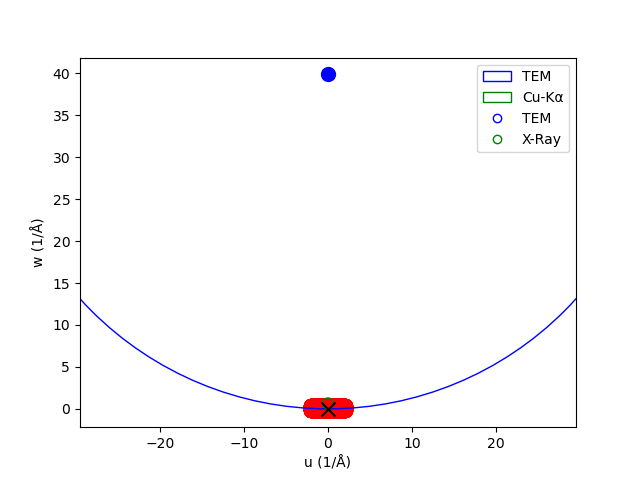

In [22]:
Ewald_Sphere  = plt.Circle((0, K0_magnitude), K0_magnitude, color='b', fill=False, label='TEM')
Ewald_Sphere_CuKa  = plt.Circle((0, 1./1.5418), 1./1.5418, color='g', fill=False,  label='Cu-Kα')

# Plot 2D
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(g[:,0], g[:,2], c='red',s=100)
ax.scatter(0, K0_magnitude, c='blue',s=100)

ax.add_artist(Ewald_Sphere)
ax.add_artist(Ewald_Sphere_CuKa)
ax.scatter(0, 0, c='black', s=100, marker='x');
ax.axis('equal')
plt.xlabel('u (1/Å)')
plt.ylabel('w (1/Å)');
line1 = plt.plot([-300], [0], color="white", marker='o', markerfacecolor="white", markeredgecolor="blue", label='TEM')
line2 = plt.plot([-300], [0], color="white", marker='o', markerfacecolor="white", markeredgecolor="green", label='X-Ray')
line3 = plt.plot([-300], [0], color="white", marker='o', markerfacecolor="white", markeredgecolor="white", linewidth = 3)
plt.legend()
plt.xlim(-15,15);

- Only if a wave vector hits a reciprocal lattice point is the Bragg condition fulfilled and we will get an intensity. Therefore, we look where the Ewald sphere cuts one of the reciprocal lattice points.
- Higher order Laue zone (HOLZ) excitations are due to diffraction from reciprocal lattice planes that are not the one the incident scattering vector end. These excitations are possible as soon as we have an Ewald sphere much larger than the inter{atom reciprocal lattice vector.  The most prominent HOLZ features in a diffraction pattern are the so called HOLZ rings. We will learn later how to use the HOLZ rings to extract information.

### Tilting

Mathematically it is equivalent to tilt the reciprocal lattice or the Ewald Sphere.

Tilting is the way to achieve exact Bragg conditions.

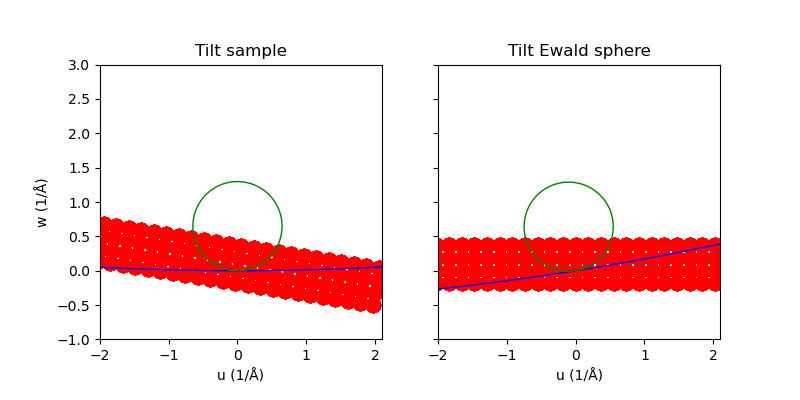

In [23]:
# ----Input ----
tilt_angle = 9.  # in degree
# --------------

tilt_angle_r = np.radians(tilt_angle)  # now in radians
rotation_matrix = np.array([[np.cos(tilt_angle_r), -np.sin(tilt_angle_r)],
                            [np.sin(tilt_angle_r), np.cos(tilt_angle_r)]])
K0_tilt = np.dot([0, K0_magnitude], rotation_matrix)
K_xray_tilt = np.dot([0, 1./1.5418], rotation_matrix)

g_tilt = g[:, [0, 2]].copy()
g_tilt  = np.dot(g_tilt, rotation_matrix)

Ewald_Sphere  = plt.Circle((0, K0_magnitude), K0_magnitude, color='b', fill=False, label='TEM')
Ewald_Sphere_CuKa  = plt.Circle((0, 1/1.5418), 1/1.5418, color='g', fill=False,  label='Cu-K$\alpha$')
Ewald_Sphere_tilt  = plt.Circle((-K0_tilt[0], K0_tilt[1]), K0_magnitude, color='b', fill=False, label='TEM')
Ewald_Sphere_CuKa_tilt  = plt.Circle((-K_xray_tilt[0], K_xray_tilt[1]),  1./1.5418, color='green', fill=False, label='TEM')

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
ax1.scatter(0, K0_magnitude, c='blue',s=100)
ax1.scatter(g_tilt [:,0], g_tilt [:,1], c='red',s=100)
ax1.add_artist(Ewald_Sphere)
ax1.add_artist(Ewald_Sphere_CuKa)
ax1.set_aspect('equal')
ax1.set_xlabel('u (1/Å)')
ax1.set_ylabel('w (1/Å)');
ax1.set_title('Tilt sample')

ax2.scatter(g[:,0], g[:,2], c='red',s=100)
ax2.scatter(-K0_tilt[0], K0_tilt[1], c='blue',s=100)
ax2.add_artist(Ewald_Sphere_tilt)
ax2.add_artist(Ewald_Sphere_CuKa_tilt)
ax2.set_xlabel('u (1/Å)')
ax2.set_aspect('equal')

ax2.set_title('Tilt Ewald sphere')
ax1.set_xlim(-2, 2.1)
ax1.set_ylim(-1, 3);


### Precise Bragg Condition

The precise Bragg condition is important in X-ray Diffraction and is the reason for the $\theta - 2\theta$ scans in X-ray diffraction experiments. 

The precise Bragg condition will become important in section of conventional TEM (two beam condition).

Obviously, angles are too small for acceleration voltages used in a TEM to show nicely in a graph.
Reduce the acceleration voltage to about 1000 to see a decent graphic with larger angles (why?).

In [24]:
import matplotlib
print(matplotlib.get_cachedir()) 

C:\Users\gduscher\.matplotlib


The wavelength for 1.0kV is : 38.76403pm
Reflection [8, 0, 0] with magnitude of reciprocal vector 1.47 1/A  has the Bragg angle 16.6°


(-1.0, 3.0)

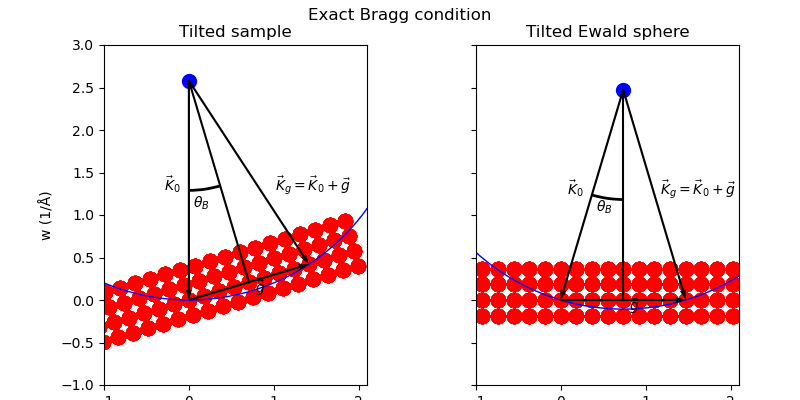

In [25]:
from matplotlib import patches
# -----Input -------
Miller_index_h = 8
acceleration_voltage_V = 1.0*1000.0 #V
# ---------------------

hkl_g=[Miller_index_h, 0, 0]
wave_length_A  = ks.get_wavelength(acceleration_voltage_V)

print(f'The wavelength for {acceleration_voltage_V/1000:.1f}kV is : {wave_length_A*100.:.5f}pm')

K0_magnitude = 1/wave_length_A


reciprocal_unit_cell = atoms.cell.reciprocal() # transposed of inverted unit_cell
g_hkl = np.dot(reciprocal_unit_cell, hkl_g) # calculate g vector for reflection
g_norm = np.linalg.norm(g_hkl)          # calculate length or norm of g vector 
theta_B = np.arcsin(g_norm/2./K0_magnitude)    #calculate Bragg angle in degree
#theta_B =g_norm/2./K0
d_theta_B = np.arctan(g_hkl[2]/g_hkl[0])
tilt_angle_rad=(theta_B-d_theta_B)

theta_B =theta_B/np.pi*180

print(f'Reflection {hkl_g} with magnitude of reciprocal vector {np.linalg.norm(g_hkl):.2f} 1/A',
      f' has the Bragg angle {theta_B:.1f}\u00b0')


# Tilted coordinates
x = 0
y = K0_magnitude
start = 0
# Tilt reciprocal lattice
c, s = np.cos(tilt_angle_rad), np.sin(tilt_angle_rad)
rot_matrix = np.array([[c, 0 ,s],[0, 1, 0],[-s, 0, c]])
g_tilt = g.copy()
g_tilt  = np.dot(g_tilt , rot_matrix)
Ewald_Sphere  = plt.Circle((x,y), K0_magnitude, color='b', fill=False, label='TEM')
theta_Arc = patches.Arc((x,y), K0_magnitude, -K0_magnitude, angle=-90-start, theta1=theta_B, theta2=0, color='black', fill=False,linewidth = 2)
g_hkl_tilt = np.dot(g_hkl , rot_matrix)

# Plot 2D
fig, (ax1, ax2) = plt.subplots(1, 2,  sharex=True, sharey=True, figsize=(8, 4))
ax1.scatter(g_tilt[:,0], g_tilt[:,2], c='red',s=100)
ax1.scatter(x,y, c='blue',s=100)

ax1.add_artist(Ewald_Sphere)
#Plot K0
ax1.quiver([x],[y],[-x],[-y], units='xy', scale =1, width = .025)
ax1.text(x/2-.1,y/2,r'$\vec{K}_0$', horizontalalignment='right')# , size=20)
#Plot Kg
ax1.quiver([x],[y],[g_hkl_tilt[0]-x],[g_hkl_tilt[2]-y], units='xy', scale =1, width = .025)
ax1.text(g_hkl_tilt[0]-.4,y/2,r'$\vec{K}_g=\vec{K}_0+\vec{g}$',  horizontalalignment='left')#, size=12)
#Plot middle line    
ax1.plot([x,g_hkl_tilt[0]/2],[y,g_hkl_tilt[2]/2],'black', )
# Plot g
ax1.quiver([0],[0],[g_hkl_tilt[0]],[g_hkl_tilt[2]], units='xy', scale =1, width = .025)
ax1.text(g_hkl_tilt[0]/2+.07,g_hkl_tilt[2]/2-.13 ,r'$\vec{g}$')#, size=12)
# Plot Brag angle
ax1.add_patch(theta_Arc)
ax1.text(x/2+.05,y/2-.2,r'$\theta_{B}$', horizontalalignment='left')#, size=12)

ax1.set_aspect('equal')
ax1.set_ylim(-2,K0_magnitude)
ax1.set_xlim(-5,15)
ax1.set_title('Tilted sample')
#plt.title('Wavevectors for exact Bragg Condition for {0} in Silicon'.format(hkl_g)) 
ax1.set_xlabel('u (1/Å)')
ax1.set_ylabel('w (1/Å)')

## titled Ewald sphere in untilted coordinates

x = g_hkl[0]/2
y = np.sqrt(K0_magnitude**2-g_norm**2/4)
start = np.arctan(x/y)/np.pi*180. # start of Arc in degree

Ewald_Sphere  = plt.Circle((x,y), K0_magnitude, color='b', fill=False, label='TEM')
theta_Arc = patches.Arc((x,y), K0_magnitude, -K0_magnitude, angle=-90-start, theta1=theta_B, theta2=0, color='black', fill=False,linewidth = 2)

ax2.scatter(g[:,0], g[:,2], c='red',s=100)
ax2.scatter(x,y, c='blue',s=100)

ax2.add_artist(Ewald_Sphere)
#Plot K0
ax2.quiver([x],[y],[-x],[-y], units='xy', scale =1, width = .025)
ax2.text(x/2-.1,y/2,r'$\vec{K}_0$', horizontalalignment='right')# , size=20)
#Plot Kg
ax2.quiver([x],[y],[g_hkl[0]-x],[g_hkl[2]-y], units='xy', scale =1, width = .025)
ax2.text(g_hkl[0]-.3,y/2,r'$\vec{K}_g=\vec{K}_0+\vec{g}$',  horizontalalignment='left')#, size=12)
#Plot middle line    
ax2.plot([x,g_hkl[0]/2],[y,g_hkl[2]/2],'black', )
# Plot g
ax2.quiver([0],[0],[g_hkl[0]],[g_hkl[2]], units='xy', scale =1, width = .025)
ax2.text(g_hkl[0]/2+.07,g_hkl[2]/2-.13 ,r'$\vec{g}$')#, size=12)
# Plot Brag angle
ax2.add_patch(theta_Arc)
ax2.text(x/2+.05,y/2-.2,r'$\theta_{B}$', horizontalalignment='left')#, size=12)

ax2.set_aspect('equal')
ax2.set_title('Tilted Ewald sphere')
#plt.title('Wavevectors for exact Bragg Condition for {0} in Silicon'.format(hkl_g)) 
ax2.set_xlabel('u (1/Å)')

fig.suptitle('Exact Bragg condition')
plt.tight_layout()
ax1.set_xlim(-1, 2.1)
ax1.set_ylim(-1, 3)


## Excitation Error

### 2D Plot of Reciprocal Lattice with Excitation Error

Here we define the excitation error.
With the wave vector coming in parallel to a zone axis, the Ewald sphere should not cut any point in reciprocal space. 

However the dimensions of a TEM specimen are rather small, for a minimum the thickness paralllel to the beam has to be in the nanometer range (<200nm). This leads to the effect that the reciprocal lattice spots now are 3 dimensional objects reflecting the specimen geometry in reciprocal space. The spots are theFourier transfrom of the specimen geometry. A normal specimen is a thin disk perpendicular to the beam and in reciprocal space it is a thin rod parallel to the wave vector.

Therefore we can excite Bragg reflections even though we not exactly cut the reflection spot with the Ewald sphere. This deviation is called excitation error and is expressed as a vector.

If this vector is inside the Ewald sphere (here pointing down) the excitation error $|\vec{s}_g|$ < 0 if the vector is outside $|\vec{s}_g|$ > 0  

The wavelength for 100.0kV is : 3.70144pm


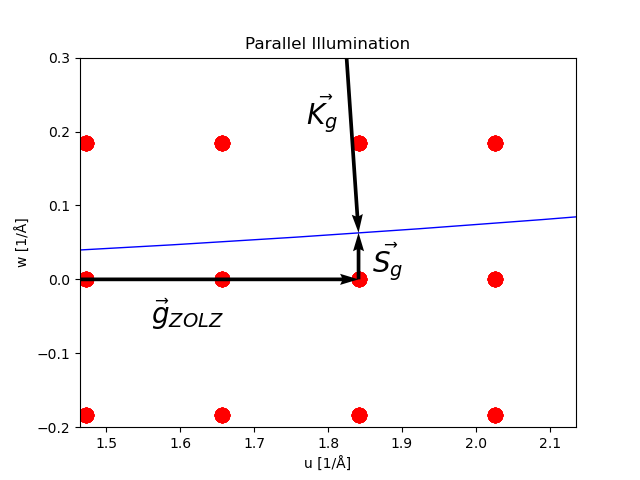

In [27]:
acceleration_voltage_V = 100.0 *1000.0 #V

wave_length_A  = ks.get_wavelength(acceleration_voltage_V)

print('The wavelength for {0:.1f}kV is : {1:.5f}pm'.format(acceleration_voltage_V/1000.,wave_length_A*100.))

K0_magnitude = 1/wave_length_A

Ewald_Sphere = plt.Circle((0, K0_magnitude), K0_magnitude, color='b', fill=False)

# Plot 2D
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(g[:,0], g[:,2], c='red',s=100)
ax.scatter(0, K0_magnitude, c='green',s=100)

ax.add_artist(Ewald_Sphere)

ax.quiver([0,0,0,g[2001,0]],[K0_magnitude,K0_magnitude,0,0],[0,g[2001,0],g[2001,0],0],[-K0_magnitude, -K0_magnitude+0.063,0,0.063], units='xy', scale =1, width = .005)

plt.text(1.86, .01,r'$\vec{S_g}$', size=20)
plt.text(1.56, -.06,r'$\vec{g}_{ZOLZ}$', size=20)
plt.text(1.77, .21,r'$\vec{K_g}$', size=20)
plt.text(.1,10,r'$\vec{K_0}$', size=20)
plt.title('Parallel Illumination')

ax.axis('equal')
plt.xlabel('u [1/Å]')
plt.ylabel('w [1/Å]')
ax.set_xlim(1.6,2.0)
ax.set_ylim(-.2,.3);

### 2D Plot of Reciprocal Lattice with Excitation Error
The same plot as above but a little zoomed out will show also the incident wave vector.

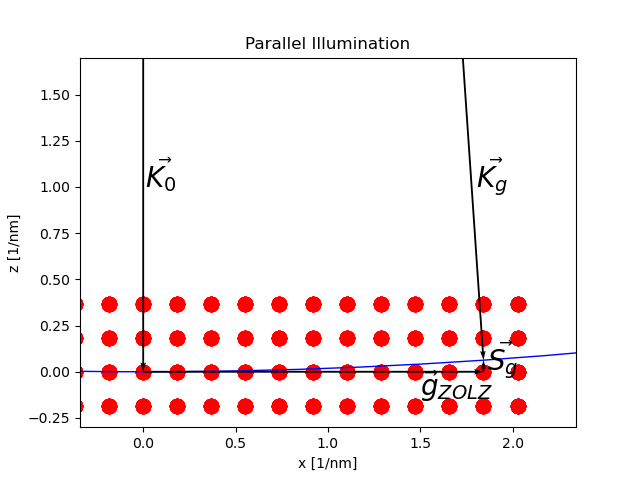

In [28]:
Ewald_Sphere = plt.Circle((0, K0_magnitude), K0_magnitude, color='b', fill=False)

# Plot 2D
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(g[:,0], g[:,2], c='red',s=100)
ax.scatter(0, K0_magnitude, c='green',s=100)

ax.add_artist(Ewald_Sphere)

ax.quiver([0,0,0,g[2001,0]],[K0_magnitude,K0_magnitude,0,0],[0,g[2001,0],g[2001,0],0],[-K0_magnitude, -K0_magnitude+0.063,0,0.063], units='xy', scale =1, width = .01)

plt.text(1.86, .01,r'$\vec{S_g}$', size=20)
plt.text(1.5, -.13,r'$\vec{g}_{ZOLZ}$', size=20)
plt.text(1.8, 1,r'$\vec{K_g}$', size=20)
plt.text(.01,1,r'$\vec{K_0}$', size=20)
plt.title('Parallel Illumination')

ax.axis('equal')
plt.xlabel('x [1/nm]')
plt.ylabel('z [1/nm]')
plt.xlim(0,2)
plt.ylim(-.3,1.7);

## Origin of Excitation Error
Part of the reason why we have an excitation error lays in the sample dimensions required for TEM investigations.

This influence of the sample geometry is further explored in these notebooks:
- [Relrod](CH2_06b-Relrod.ipynb)
- [Fourier Transform Laboratroy](CH2_06b-3D_FFT.ipynb)

## Center of Ewald Shere
So far we have considered the incident wave vector to be parallel to the Z-axis. 
However, we need to know the center of the Ewald sphere for any zone axis.


In [29]:
# INPUT
zone_hkl = np.array([1,1,0])

U0 = 0
for atom in atoms:
    U0 += ks.feq(atom.symbol,0)*0.023933754

volume =  atoms.cell.volume  # Needs to be in Angstrom for form factors
AngstromConversion = 1.0e10  # So [1A (in m)] * AngstromConversion = 1
NanometerConversion = 1.0e9 

ScattFacToVolts=(scipy.constants.h**2)*(AngstromConversion**2)/(2*np.pi*scipy.constants.m_e*scipy.constants.e)*volume
U0=U0*ScattFacToVolts
print('The inner potential is {0:.1f}kV'.format(U0/1000))

incident_wave_vector_vacuum = 1/wave_length_A
K0_magnitude = incident_wave_vector = np.sqrt(1/wave_length_A**2 + U0 )#1/Ang

center_ewald = np.dot(zone_hkl,reciprocal_lattice)
center_ewald = center_ewald /np.linalg.norm(center_ewald)* incident_wave_vector
 
normal = zone_hkl/ np.linalg.norm(zone_hkl)
print('Center of Ewald sphere ',center_ewald)

The inner potential is 8.5kV
Center of Ewald sphere  [68.07196543 68.07196543  0.        ]


## Possible Reflections
must be within the excitation error to the Ewald sphere.

Find all Miller indices whose reciprocal point lays near the Ewald sphere with radius $K_0$  within a maximum excitation error $S_g$

with $S_g \approx (K_0^2 -|\vec{K_0}+\vec{g}|^2)/ 2K_0$

First we produce all Miller indices up to a maximum value of "hkl_max" and then we check whether they fullfil above condition.

Please change "hkl_max" and the maximum excitation error "Sg_max" and see what happens.

In [32]:
# INPUT 
hkl_max = 25#  maximum allowed Miller index
Sg_max = .1 # 1/nm  maximum allowed excitation error

h  = np.linspace(-hkl_max,hkl_max,2*hkl_max+1)   # all evaluated single Miller Indices
hkl  = np.array(list(itertools.product(h,h,h) )) # all evaluated Miller indices
g = np.dot(hkl,reciprocal_lattice)               # all evaluated reciprocal lattice points

# Calculate exitation errors for all reciprocal lattice points
S = []
for i  in range(len(g)):
    ## Zuo and Spence, 'Adv TEM', 2017 -- Eq 3:14
    S.append(float((K0_magnitude**2-np.linalg.norm(g[i] - center_ewald)**2)/(2*K0_magnitude)))
S = np.array(S)

# Determine reciprocal lattice points with excitation error less than the maximum allowed one: Sg_max
reflections = abs(S)< Sg_max

Sg = S[reflections]
g_hkl =g[reflections]
print(g_hkl.shape)
hkl = hkl[reflections]
 
print ('Of the {0} tested reciprocal lattice points, {1} have an excitation error less than {2:.2f} 1/nm'.format( len(g) , len(g_hkl), Sg_max))

(3869, 3)
Of the 132651 tested reciprocal lattice points, 3869 have an excitation error less than 0.10 1/nm


## Conclusion

The scattering geometry provides all the tools to determine which reciprocal lattice points are possible and which of them are allowed and which are forbidden.



## Navigation

- <font size = "3">  **Back: [Analyzing Ring Diffraction Pattern](CH2_05-Diffraction_Rings)** </font>
- <font size = "3">  **Next: [Plotting of Diffraction Pattern](CH2_07-Plotting_Diffraction_Pattern.ipynb)** </font>
- <font size = "3">  **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>
